In [1]:
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
import cv2


Bad key text.latex.preview in file c:\Users\johng\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\johng\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\johng\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

In [2]:
DIRECTORY = 'train'


files = os.listdir(DIRECTORY)

In [3]:
TRAIN_SIZE = 100
BATCH_SIZE = 5
OUTPUT_SIZE = 50

OUTPUT_SIZE -= OUTPUT_SIZE%4

x_train=[]

for i in range(0, TRAIN_SIZE):
    added=[]
    img = Image.open(DIRECTORY+'\\'+files[i])
    img=img.resize((OUTPUT_SIZE, OUTPUT_SIZE))
    for i0 in range(OUTPUT_SIZE):
        for i1 in range(OUTPUT_SIZE):
            added.append(img.getpixel((i1,i0)))
    x_train.append([added])

x_train=np.array(x_train)
x_train = x_train / 255
x_train = np.reshape(x_train, (len(x_train), OUTPUT_SIZE, OUTPUT_SIZE, 3))

BUFFER_SIZE = x_train.shape[0]
BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE

x_train = x_train[:BUFFER_SIZE]


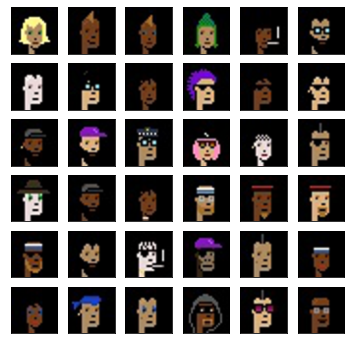

In [4]:
SIZE = 6

plt.figure(figsize=(SIZE, SIZE))
num=1
for i in range(0, SIZE):
    for j in range(0, SIZE):
        ax = plt.subplot(SIZE, SIZE, num)
        plt.imshow(x_train[num-1, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1
plt.show()

In [5]:
INPUT_DIM = 5

generator = tf.keras.Sequential([
    Dense((OUTPUT_SIZE//4) * (OUTPUT_SIZE//4) * 256, activation='relu', input_shape=(INPUT_DIM,)),
    BatchNormalization(),
    Reshape((OUTPUT_SIZE//4, OUTPUT_SIZE//4, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])
#print(generator.summary())


discriminator = tf.keras.Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[OUTPUT_SIZE, OUTPUT_SIZE, 3]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Flatten(),
    Dense(1),
])
#print(discriminator.summary())

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, INPUT_DIM])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

    for epoch in range(1, epochs + 1):
        
        is_print=((epoch-2) % PRINT_STEP == 0)
        if is_print:
            print(f'{epoch}/{EPOCHS}: ', end='')

        start = time.time()
        n = 0
        
        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if (n % th == 0 and is_print): print('=', end='')
            n += 1
            
        history += [gen_loss_epoch / n]
        if is_print:
            print(': ' + str(history[-1]))
            print('epoch time {} is {} seconds'.format(epoch, time.time() - start))
            print('Approximate remaining time: {} seconds'.format(int((time.time() - start)*(epochs - epoch))))
            print('')

    return history

In [7]:
EPOCHS = 500
PRINT_STEP = 10

history = train(train_dataset, EPOCHS)

2/500: ==========: tf.Tensor(2.745706, shape=(), dtype=float32)
epoch time 2 is 3.892594575881958 seconds
Approximate remaining time: 1944 seconds

12/500: ==========: tf.Tensor(4.181447, shape=(), dtype=float32)
epoch time 12 is 0.17852234840393066 seconds
Approximate remaining time: 87 seconds

22/500: ==========: tf.Tensor(3.1121066, shape=(), dtype=float32)
epoch time 22 is 0.15658211708068848 seconds
Approximate remaining time: 74 seconds

32/500: ==========: tf.Tensor(2.1575809, shape=(), dtype=float32)
epoch time 32 is 0.1575791835784912 seconds
Approximate remaining time: 73 seconds

42/500: ==========: tf.Tensor(1.4120053, shape=(), dtype=float32)
epoch time 42 is 0.16655445098876953 seconds
Approximate remaining time: 76 seconds

52/500: ==========: tf.Tensor(1.1459353, shape=(), dtype=float32)
epoch time 52 is 0.15259313583374023 seconds
Approximate remaining time: 68 seconds

62/500: ==========: tf.Tensor(1.121004, shape=(), dtype=float32)
epoch time 62 is 0.141621828079223

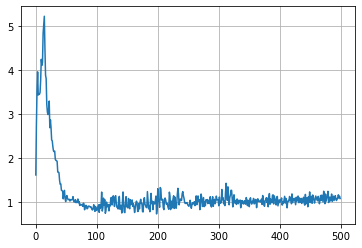

In [8]:
plt.plot(history)
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 12ms/step


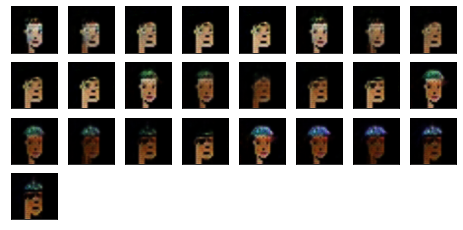

In [9]:
SIZE = 8
n = SIZE // 3

plt.figure(figsize=(SIZE, SIZE))

num = 1
for i in range(-n, n + 1):
    for j in range(-n, n + 1):
        ax = plt.subplot(SIZE, SIZE, num)
        key=np.resize([0.5 * i / n, 0.5 * j / n],(1, INPUT_DIM))
        img = generator.predict(key)
        plt.imshow(img[0, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1

plt.show()

1/1 [==============================] - 0s 51ms/step


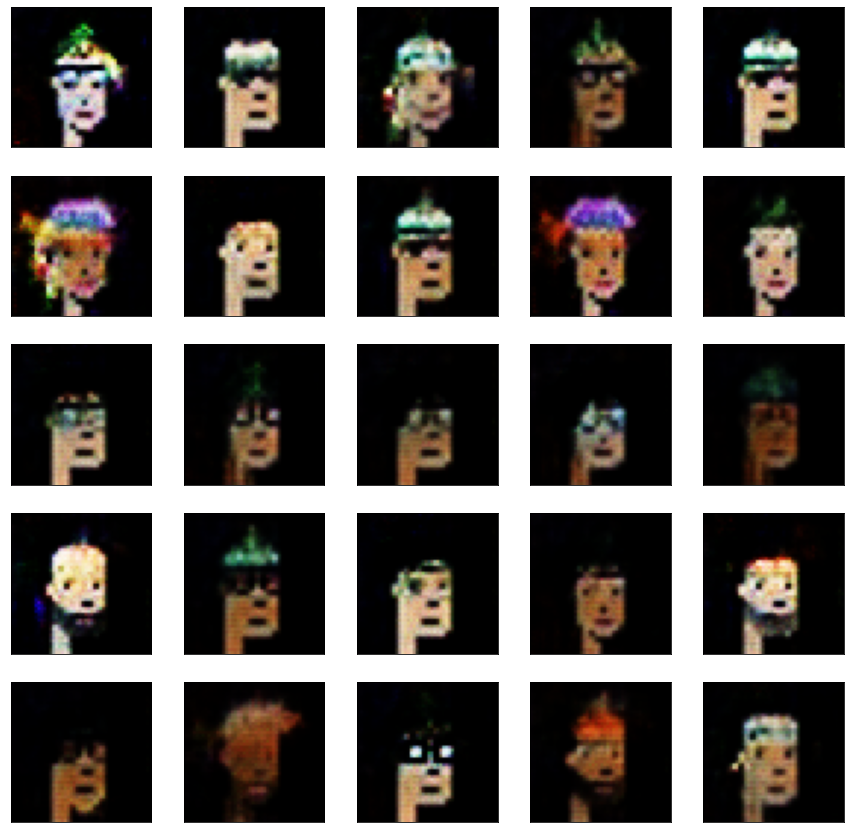

In [10]:
SIZE = 5

plt.figure(figsize=(SIZE*3, SIZE*3))

num = 1
for i in range(0 ,SIZE):
    for j in range(0, SIZE):
        ax = plt.subplot(SIZE, SIZE, num)
        img = generator.predict(tf.random.normal([1, INPUT_DIM]))
        plt.imshow(img[0, :, :, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        num += 1
#figure(figsize=(8, 6), dpi=80)
plt.show()

1/1 [==============================] - 0s 14ms/step


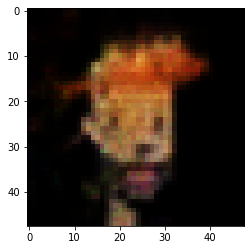

In [11]:
img = generator.predict(tf.random.normal([1, INPUT_DIM]))
plt.imshow(img[0, :, :, :])
plt.show()

In [12]:
print(type(generator))

<class 'keras.engine.sequential.Sequential'>


In [13]:
from keras.models import load_model

generator.save('my_model.h5')

In [14]:
model =  tf.keras.models.load_model('my_model.h5')

In [20]:
model.compile(optimizer = generator_optimizer, loss=None)

1/1 [==============================] - 0s 22ms/step


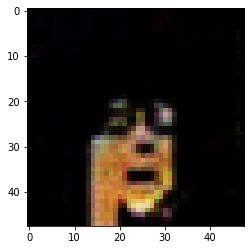

In [23]:
img = model.predict(tf.random.normal([1, INPUT_DIM]))
plt.imshow(img[0, :, :, :])
plt.show()